# Experimentos de EDAs sobre OneMax
Este notebook contiene las implementaciones de tres algoritmos de optimización:
- UMDA (Univariate Marginal Distribution Algorithm)
- MIMIC (Mutual Information Maximization for Input Clustering)
- Algoritmo Genético Básico (GA)

Se evalúan sobre el problema OneMax y se analizan métricas como convergencia, diversidad y estabilidad.

In [111]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns
sns.set(style='whitegrid')

In [112]:
def onemax(individual):
    return np.sum(individual)

def initialize_population(pop_size, n_bits):
    return np.random.randint(0, 2, size=(pop_size, n_bits))

def select_best(population, fitness, num_selected):
    idx = np.argsort(fitness)[-num_selected:]
    return population[idx]

def compute_diversity(population):
    n = len(population)
    dists = [np.sum(population[i] != population[j]) for i in range(n) for j in range(i+1, n)]
    return np.mean(dists) if dists else 0

In [113]:
def estimate_probabilities(selected):
    return np.mean(selected, axis=0)

def sample_from_probabilities(probabilities, pop_size):
    return (np.random.rand(pop_size, len(probabilities)) < probabilities).astype(int)

def run_umda(n_bits=50, pop_size=100, selected_ratio=0.5, max_generations=100):
    population = initialize_population(pop_size, n_bits)
    history = []
    for generation in range(max_generations):
        fitness = np.array([onemax(ind) for ind in population])
        best = np.max(fitness)
        mean = np.mean(fitness)
        diversity = compute_diversity(population)
        history.append((generation, best, mean, diversity))
        if best == n_bits:
            break
        selected = select_best(population, fitness, int(pop_size * selected_ratio))
        probs = estimate_probabilities(selected)
        population = sample_from_probabilities(probs, pop_size)
    return pd.DataFrame(history, columns=['Generation', 'Best', 'Mean', 'Diversity'])

In [114]:
def crossover(parent1, parent2):
    point = np.random.randint(1, len(parent1) - 1)
    return np.concatenate([parent1[:point], parent2[point:]])

def mutate(individual, mutation_rate=0.01):
    mutation = np.random.rand(len(individual)) < mutation_rate
    return np.bitwise_xor(individual, mutation.astype(int))

def run_ga(n_bits=50, pop_size=100, selected_ratio=0.5, mutation_rate=0.01, max_generations=100):
    population = initialize_population(pop_size, n_bits)
    history = []
    for generation in range(max_generations):
        fitness = np.array([onemax(ind) for ind in population])
        best = np.max(fitness)
        mean = np.mean(fitness)
        diversity = compute_diversity(population)
        history.append((generation, best, mean, diversity))
        if best == n_bits:
            break
        num_selected = int(pop_size * selected_ratio)
        selected = select_best(population, fitness, num_selected)
        offspring = []
        while len(offspring) < pop_size:
            p1, p2 = selected[np.random.randint(num_selected)], selected[np.random.randint(num_selected)]
            child = crossover(p1, p2)
            child = mutate(child, mutation_rate)
            offspring.append(child)
        population = np.array(offspring)
    return pd.DataFrame(history, columns=['Generation', 'Best', 'Mean', 'Diversity'])

In [115]:
def conditional_entropy(x, y):
    joint_counts = Counter(zip(x, y))
    x_counts = Counter(x)
    total = len(x)
    cond_entropy = 0.0
    for (xi, yi), joint in joint_counts.items():
        px = x_counts[xi] / total
        pxy = joint / total
        pyx = pxy / px
        cond_entropy -= pxy * np.log2(pyx + 1e-12)
    return cond_entropy

def find_variable_order(selected):
    n_bits = selected.shape[1]
    remaining = list(range(n_bits))
    order = [remaining.pop(0)]
    while remaining:
        cond_entropies = [conditional_entropy(selected[:, i], selected[:, order[-1]]) for i in remaining]
        next_var = remaining[np.argmin(cond_entropies)]
        order.append(next_var)
        remaining.remove(next_var)
    return order

def build_conditional_probabilities(selected, order):
    cond_probs = {}
    for i, var in enumerate(order):
        if i == 0:
            cond_probs[var] = np.mean(selected[:, var])
        else:
            prev_var = order[i - 1]
            table = {}
            for v in [0, 1]:
                subset = selected[selected[:, prev_var] == v]
                table[v] = np.mean(subset[:, var]) if len(subset) > 0 else 0.5
            cond_probs[var] = table
    return cond_probs

def sample_conditional(cond_probs, order, pop_size):
    samples = np.zeros((pop_size, len(order)), dtype=int)
    for i in range(pop_size):
        for j, var in enumerate(order):
            if j == 0:
                samples[i, var] = np.random.rand() < cond_probs[var]
            else:
                prev_var = order[j - 1]
                prev_val = samples[i, prev_var]
                samples[i, var] = np.random.rand() < cond_probs[var][prev_val]
    return samples

def run_mimic(n_bits=50, pop_size=100, selected_ratio=0.5, max_generations=100):
    population = initialize_population(pop_size, n_bits)
    history = []
    for generation in range(max_generations):
        fitness = np.array([onemax(ind) for ind in population])
        best = np.max(fitness)
        mean = np.mean(fitness)
        diversity = compute_diversity(population)
        history.append((generation, best, mean, diversity))
        if best == n_bits:
            break
        selected = select_best(population, fitness, int(pop_size * selected_ratio))
        order = find_variable_order(selected)
        cond_probs = build_conditional_probabilities(selected, order)
        population = sample_conditional(cond_probs, order, pop_size)
    return pd.DataFrame(history, columns=['Generation', 'Best', 'Mean', 'Diversity'])

In [116]:
umda_df = run_umda()
ga_df = run_ga()
mimic_df = run_mimic()

# Ejecutar los tres algoritmos y comparar visualmente
umda_df.to_csv("umda_onemax.csv", index=False)
ga_df.to_csv("ga_onemax.csv", index=False)
mimic_df.to_csv("mimic_onemax.csv", index=False)


   Generation  Best   Mean  Diversity
0           0    34  24.62  24.894545
1           1    37  27.42  24.390303
2           2    37  30.39  23.107273
3           3    39  32.71  21.354141
4           4    41  35.32  19.469495
5           5    44  37.97  16.906465
6           6    46  40.11  14.502020
7           7    48  42.00  11.949899
8           8    48  43.85   9.394949
9           9    50  45.42   7.405657     Generation  Best   Mean  Diversity
0            0    35  25.13  24.968283
1            1    33  28.26  24.027071
2            2    35  30.34  22.650909
3            3    38  32.39  20.899596
4            4    39  34.08  19.294545
5            5    41  35.40  18.046869
6            6    42  36.96  16.100606
7            7    42  38.41  14.553737
8            8    43  39.44  13.399596
9            9    43  40.19  12.484242
10          10    45  40.85  11.830909
11          11    45  41.60  11.097374
12          12    45  42.25  10.555354
13          13    46  42.92   9.9507

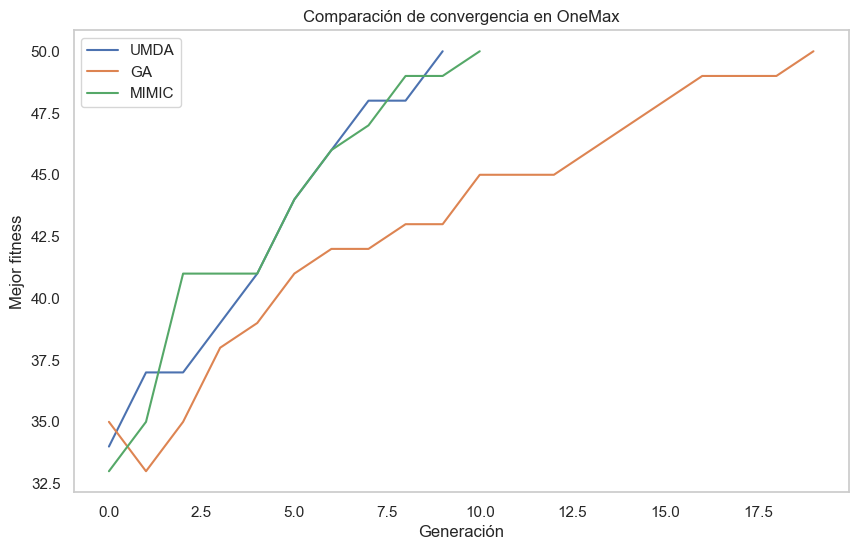

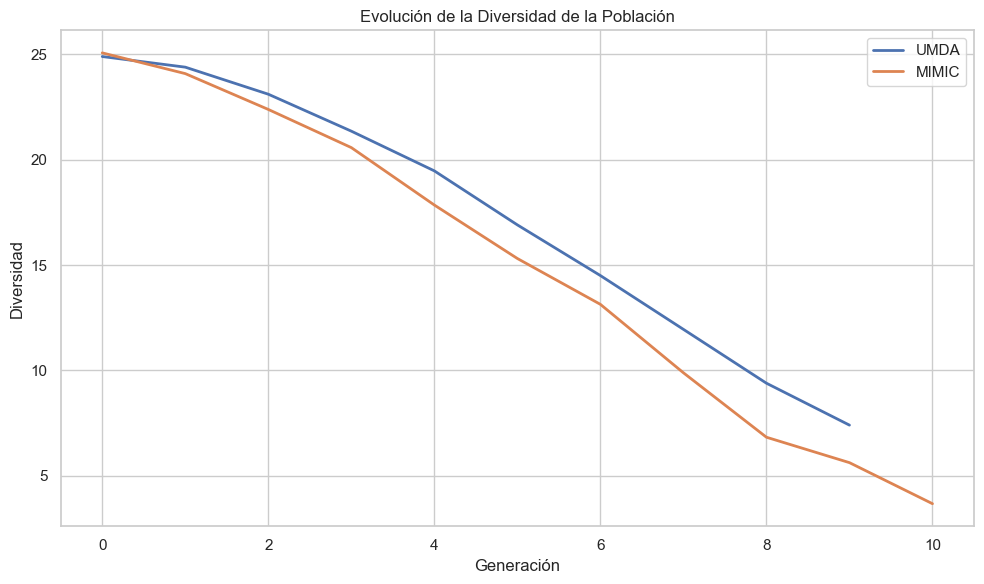

In [117]:
print(umda_df, ga_df , mimic_df)

plt.figure(figsize=(10, 6))
plt.plot(umda_df['Generation'], umda_df['Best'], label="UMDA")
plt.plot(ga_df['Generation'], ga_df['Best'], label="GA")
plt.plot(mimic_df['Generation'], mimic_df['Best'], label="MIMIC")
plt.xlabel("Generación")
plt.ylabel("Mejor fitness")
plt.title("Comparación de convergencia en OneMax")
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(umda_df['Generation'], umda_df['Diversity'], label="UMDA", linewidth=2)
plt.plot(mimic_df['Generation'], mimic_df['Diversity'], label="MIMIC", linewidth=2)
plt.xlabel("Generación")
plt.ylabel("Diversidad")
plt.title("Evolución de la Diversidad de la Población")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

 Interpretación de la convergencia
 
🔵 UMDA (línea azul)
Es el que converge más rápido al fitness óptimo.

Alcanza el valor máximo en menos de 10 generaciones.

Su progreso es estable y ascendente, con ligeras oscilaciones.

🟢 MIMIC (línea verde)
Muy competitivo con UMDA, pero ligeramente más lento.

También alcanza el valor óptimo, pero un poco después.

El comportamiento es suave y progresivo, lo que sugiere una buena explotación.

🟠 GA (línea naranja)
Es claramente el más lento de los tres.

Aunque llega al óptimo, lo hace en alrededor de 20 generaciones.

Tiene una convergencia más irregular, con altibajos.

In [118]:
def run_umda_with_probs(n_bits=50, pop_size=100, selected_ratio=0.5, max_generations=30):
    population = initialize_population(pop_size, n_bits)
    history = []
    prob_history = []

    for generation in range(max_generations):
        fitness = np.array([onemax(ind) for ind in population])
        best = np.max(fitness)
        mean = np.mean(fitness)
        history.append((generation, best, mean))

        selected = select_best(population, fitness, int(pop_size * selected_ratio))
        probs = estimate_probabilities(selected)
        prob_history.append(probs)

        population = sample_from_probabilities(probs, pop_size)

    df_history = pd.DataFrame(history, columns=["Generation", "Best", "Mean"])
    prob_matrix = np.array(prob_history)  # shape: (generations, n_bits)
    return df_history, prob_matrix


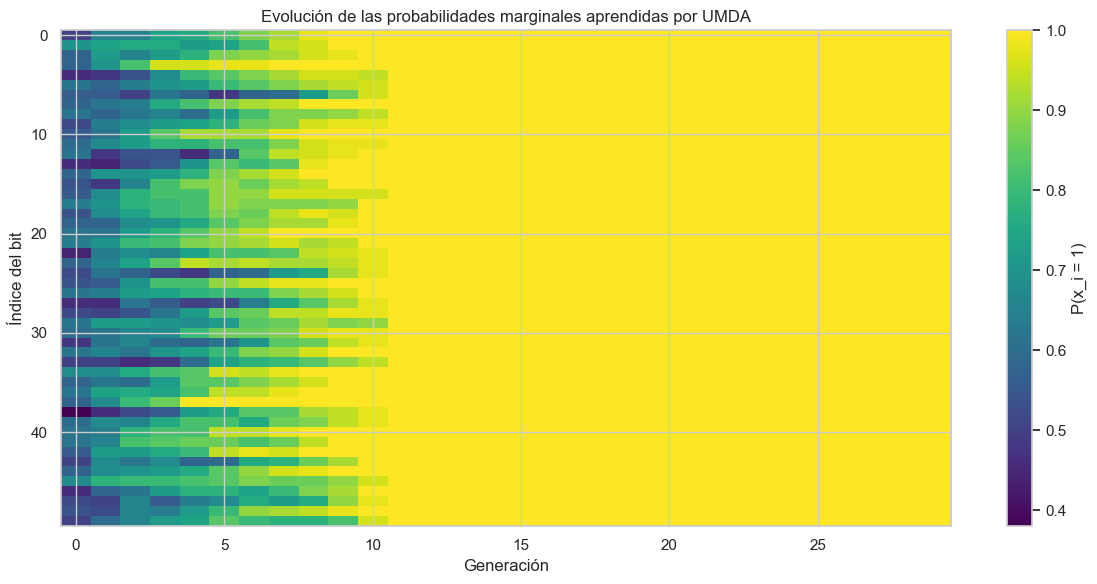

In [119]:
# Ejecutar UMDA y visualizar la evolución de las probabilidades marginales
umda_hist, umda_probs = run_umda_with_probs()

plt.figure(figsize=(12, 6))
plt.imshow(umda_probs.T, aspect="auto", cmap="viridis", interpolation="nearest")
plt.colorbar(label="P(x_i = 1)")
plt.xlabel("Generación")
plt.ylabel("Índice del bit")
plt.title("Evolución de las probabilidades marginales aprendidas por UMDA")
plt.tight_layout()
plt.show()


In [120]:
def run_mimic_with_structure(n_bits=50, pop_size=100, selected_ratio=0.5, max_generations=30):
    population = initialize_population(pop_size, n_bits)
    history = []
    order_history = []

    for generation in range(max_generations):
        fitness = np.array([onemax(ind) for ind in population])
        best = np.max(fitness)
        mean = np.mean(fitness)
        history.append((generation, best, mean))

        selected = select_best(population, fitness, int(pop_size * selected_ratio))
        order = find_variable_order(selected)
        order_history.append(order)

        cond_probs = build_conditional_probabilities(selected, order)
        population = sample_conditional(cond_probs, order, pop_size)

    df_history = pd.DataFrame(history, columns=["Generation", "Best", "Mean"])
    order_matrix = np.array(order_history)
    return df_history, order_matrix


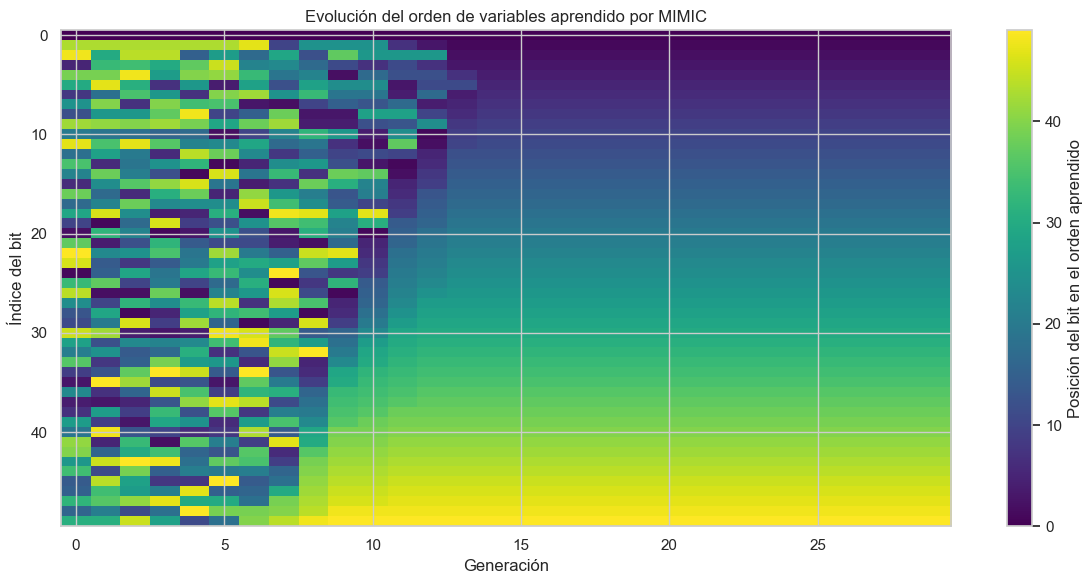

In [121]:
# Ejecutar MIMIC y visualizar el orden de variables aprendido
mimic_hist, mimic_order = run_mimic_with_structure()

plt.figure(figsize=(12, 6))
plt.imshow(mimic_order.T, aspect="auto", cmap="viridis", interpolation="nearest")
plt.colorbar(label="Posición del bit en el orden aprendido")
plt.xlabel("Generación")
plt.ylabel("Índice del bit")
plt.title("Evolución del orden de variables aprendido por MIMIC")
plt.tight_layout()
plt.savefig("mimic_order_evolution.png", dpi=300)
plt.show()
